In [1]:
import numpy as np
import pandas as pd
import torch
from scipy.linalg import toeplitz
from scipy.stats import norm

import matplotlib.pyplot as plt
from tableone import TableOne
from sksurv.nonparametric import kaplan_meier_estimator

from utils import data_processing, visualization
from utils.simulations import *
from execute import surv_hivae, surv_gan, surv_vae
#from utils.metrics import log_rank, cox_estimation


[KeOps] Warning : There were warnings or errors :
/bin/sh: brew: command not found

[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.

[KeOps] Warning : There were warnings or errors :
/bin/sh: brew: command not found

[KeOps] Warning : OpenMP library not found, it must be downloaded through Homebrew for apple Silicon chips
[KeOps] Warning : OpenMP support is not available. Disabling OpenMP.


In [2]:
n_samples = 600
n_features_bytype = 4
n_features_multiplier = 3 

In [3]:
beta_features = np.concatenate([weights_sparse_exp(n_features_bytype,3),weights_sparse_exp(n_features_bytype,3),
                       weights_sparse_exp(n_features_bytype,3)])
treatment_effect = 0.5

In [4]:
control, treated, types = simulation(beta_features , treatment_effect , n_samples,surv_type = "surv_weibull")
control = control.drop(columns='treatment')
treated = treated.drop(columns='treatment')

In [5]:
control.head()

,0,1,2,3,4,5,6,7,8,9,10,11,time,censor
0,0.159315,0.369346,0.510315,0.392884,0.337157,0.708470,0.291083,1.029441,1.0,1.0,1.0,0.0,1.824054,1
1,-0.532082,-1.246393,-1.657402,-0.410628,0.574082,0.107536,0.447214,0.574744,0.0,0.0,1.0,1.0,0.623777,1
3,-0.040744,-0.876258,-0.536674,-1.644913,1.912735,1.070529,0.735455,0.142748,1.0,1.0,0.0,1.0,1.537484,1
4,-0.916806,0.617375,-0.318758,-0.237926,0.086405,0.437843,2.414661,0.814462,0.0,1.0,1.0,1.0,0.826270,1
6,-0.936543,-1.263675,-0.305885,-0.196679,0.369868,1.226304,0.818172,2.084332,1.0,1.0,0.0,0.0,0.585245,1


In [6]:
print(np.mean(control['censor']),np.mean(treated['censor']))

0.8668730650154799 0.8953068592057761


In [7]:
dataset_name = "Simulations"
data_file_control= "./dataset/" + dataset_name + "/data_control.csv"
feat_types_file_control = "./dataset/" + dataset_name + "/data_types_control.csv"
data_file_treated= "./dataset/" + dataset_name + "/data_treated.csv"
feat_types_file_treated= "./dataset/" + dataset_name + "/data_types_treated.csv"

# If the dataset has no missing data, leave the "miss_file" variable empty
miss_file = "dataset/" + dataset_name + "/Missing.csv"
true_miss_file = None

In [8]:
control.to_csv(data_file_control,index=False , header=False)
types.to_csv(feat_types_file_control)
treated.to_csv(data_file_treated,index=False , header=False)
types.to_csv(feat_types_file_treated)

## Generation

In [9]:
# Load and transform control data
data_init_control_encoded, feat_types_dict, miss_mask_control, true_miss_mask_control, _ = data_processing.read_data(data_file_control, 
                                                                                                             feat_types_file_control, 
                                                                                                             miss_file, true_miss_file)
data_init_control = data_processing.discrete_variables_transformation(data_init_control_encoded, feat_types_dict)

# Load and transform treated data
data_init_treated_encoded, _, _, _, _ = data_processing.read_data(data_file_treated, feat_types_file_treated, 
                                                         miss_file, true_miss_file)
data_init_treated = data_processing.discrete_variables_transformation(data_init_treated_encoded, feat_types_dict)

In [10]:
fnames = types['name'][:-1].tolist()
fnames.append("time")#.append("censor")
fnames.append("censor")

In [11]:
# Format data in dataframe
df_init_treated = pd.DataFrame(data_init_treated.numpy(), columns=fnames)
df_init_control = pd.DataFrame(data_init_control.numpy(), columns=fnames)

# Update the data
df_init_treated["treatment"] = 1
df_init_control["treatment"] = 0
df_init = pd.concat([df_init_control, df_init_treated], ignore_index=True)

In [12]:
feat_types_dict_all = feat_types_dict.copy()
feat_types_dict_all.append({'name': 'treatment', 'type': 'cat', 'dim': '1', 'nclass': '2'})
#visualization.plot_data(df_init.to_numpy(), feat_types_dict_all, feat_comparison_name='treatment')

In [13]:
# the datasets used for training is data_init_control
T_surv = torch.Tensor(df_init_control.time)
T_surv_norm = (T_surv - T_surv.min()) / (T_surv.max() - T_surv.min())
n_intervals = 5
T_intervals = torch.linspace(0., T_surv_norm.max(), n_intervals)
T_intervals = torch.cat([T_intervals, torch.tensor([2 * T_intervals[-1] - T_intervals[-2]])])
intervals = [(T_intervals[i].item(), T_intervals[i + 1].item()) for i in range(len(T_intervals) - 1)]

In [14]:
n_generated_dataset = 1
data_gen_control_hivae = surv_hivae.run((data_init_control_encoded, intervals), miss_mask_control, 
                                  true_miss_mask_control, feat_types_file_control, feat_types_dict, n_generated_dataset,verbose=False)

data_gen_control_survgan = surv_gan.run(data_init_control, columns=fnames, target_column="censor", 
                                time_to_event_column="time", n_generated_sample=n_generated_dataset)


data_gen_control_survvae = surv_vae.run(data_init_control, columns=fnames, target_column="censor", 
                                time_to_event_column="time", n_generated_sample=n_generated_dataset)

[2025-05-23T21:17:49.359378+0200][70339][CRITICAL] Error importing TabularGoggle: No module named 'dgl'
[2025-05-23T21:17:49.360673+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-23T21:17:50.537629+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
  9%|██████                                                          | 949/10000 [00:25<04:05, 36.89it/s]
[2025-05-23T21:18:16.900885+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-23T21:18:16.912545+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 50%|█████████████████████████

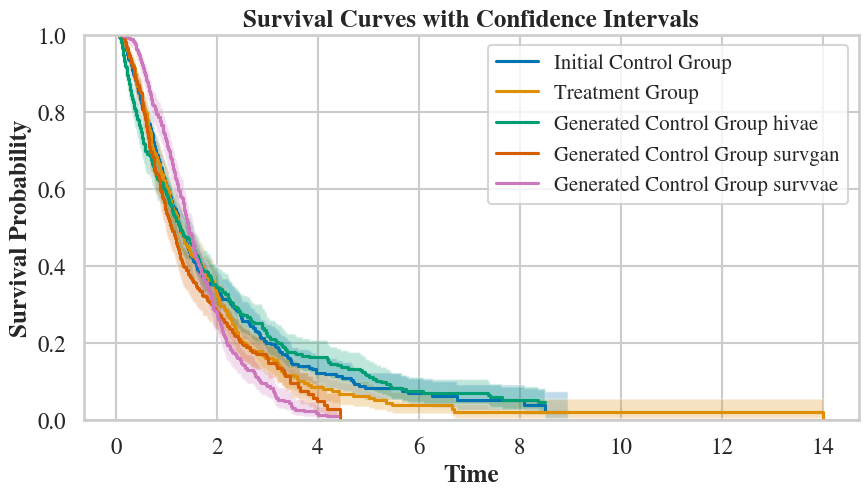

In [15]:
surv_time_control_init  = control['time'].values
surv_ind_control_init = control['censor'].values.astype(bool)

surv_time_treated_init = treated['time'].values
surv_ind_treated_init = treated['censor'].values.astype(bool)

i=0
df_syn_sel = pd.DataFrame(data_gen_control_hivae[i].numpy(), columns=fnames)
surv_time_control_gen = df_syn_sel['time'].values
surv_ind_control_gen = df_syn_sel['censor'].values.astype(bool)

df_syn_sel2 = pd.DataFrame(data_gen_control_survgan[i].numpy(), columns=fnames)
surv_time_control_gen2 = df_syn_sel2['time'].values
surv_ind_control_gen2 = df_syn_sel2['censor'].values.astype(bool)

df_syn_sel3 = pd.DataFrame(data_gen_control_survvae[i].numpy(), columns=fnames)
surv_time_control_gen3 = df_syn_sel3['time'].values
surv_ind_control_gen3 = df_syn_sel3['censor'].values.astype(bool)

uniq_time_control_init, surv_prob_control_init, conf_int_control_init = kaplan_meier_estimator(surv_ind_control_init, surv_time_control_init, conf_type="log-log")
uniq_time_treated_init, surv_prob_treated_init, conf_int_treated_init = kaplan_meier_estimator(surv_ind_treated_init, surv_time_treated_init, conf_type="log-log")
uniq_time_control_gen, surv_prob_control_gen, conf_int_control_gen = kaplan_meier_estimator(surv_ind_control_gen, surv_time_control_gen, conf_type="log-log")
uniq_time_control_gen2, surv_prob_control_gen2, conf_int_control_gen2 = kaplan_meier_estimator(surv_ind_control_gen2, surv_time_control_gen2, conf_type="log-log")
uniq_time_control_gen3, surv_prob_control_gen3, conf_int_control_gen3 = kaplan_meier_estimator(surv_ind_control_gen3, surv_time_control_gen3, conf_type="log-log")

plt.figure(figsize=(10, 5))
plt.step(uniq_time_control_init, surv_prob_control_init, where="post", label="Initial Control Group")
plt.fill_between(uniq_time_control_init, conf_int_control_init[0], conf_int_control_init[1], alpha=0.25, step="post")

plt.step(uniq_time_treated_init, surv_prob_treated_init, where="post", label="Treatment Group")
plt.fill_between(uniq_time_treated_init, conf_int_treated_init[0], conf_int_treated_init[1], alpha=0.25, step="post")

plt.step(uniq_time_control_gen, surv_prob_control_gen, where="post", label="Generated Control Group hivae")
plt.fill_between(uniq_time_control_gen, conf_int_control_gen[0], conf_int_control_gen[1], alpha=0.25, step="post")


plt.step(uniq_time_control_gen2, surv_prob_control_gen2, where="post", label="Generated Control Group survgan")
plt.fill_between(uniq_time_control_gen2, conf_int_control_gen2[0], conf_int_control_gen2[1], alpha=0.25, step="post")


plt.step(uniq_time_control_gen3, surv_prob_control_gen3, where="post", label="Generated Control Group survvae")
plt.fill_between(uniq_time_control_gen3, conf_int_control_gen3[0], conf_int_control_gen3[1], alpha=0.25, step="post")


plt.ylim(0, 1)
plt.legend(fontsize=15)
plt.xlabel("Time", fontweight="semibold")
plt.ylabel("Survival Probability", fontweight="semibold")
plt.title("Survival Curves with Confidence Intervals", fontweight="bold")
plt.show()

In [16]:
print("log rank pvalues, initial", compute_logrank_test(control, treated) , "hivae" ,compute_logrank_test(df_syn_sel, treated),
      "survgan" ,compute_logrank_test(df_syn_sel2, treated), "survvae" ,compute_logrank_test(df_syn_sel3, treated))

log rank pvalues, initial 1.3587550239867392 hivae 1.5171070689191695 survgan 1.7593897225971742 survvae 1.7970184460445076


## Replication

In [17]:
n_generated_dataset = 50
dataset_name = "Simulations"

In [18]:
treat_effects = np.arange(0,1.1,0.2)
print(treat_effects)

[0.  0.2 0.4 0.6 0.8 1. ]


## Independent

In [19]:
M = 100
log_p_value = []
log_p_value_gen_hivae = []
log_p_value_gen_survgan = []
log_p_value_gen_survvae = []
simu_num = []
H0_coef = []
for t in treat_effects:
    treatment_effect = t
    for m in np.arange(M):
        if m % 10 == 0:
            print(m)
        control, treated, types = simulation(beta_features , treatment_effect , n_samples,surv_type = "surv_weibull")
        control = control.drop(columns='treatment')
        treated = treated.drop(columns='treatment')
        
        data_file_control= "./dataset/" + dataset_name + "/data_control_gen.csv"
       
        control.to_csv(data_file_control,index=False , header=False)

        
        T_surv = torch.Tensor(df_init_control.time)
        T_surv_norm = (T_surv - T_surv.min()) / (T_surv.max() - T_surv.min())
        n_intervals = 5
        T_intervals = torch.linspace(0., T_surv_norm.max(), n_intervals)
        T_intervals = torch.cat([T_intervals, torch.tensor([2 * T_intervals[-1] - T_intervals[-2]])])
        intervals = [(T_intervals[i].item(), T_intervals[i + 1].item()) for i in range(len(T_intervals) - 1)]
        
        p_value_init = compute_logrank_test(control, treated)
    
        
    
        # Load and transform control data
        data_init_control_encoded, feat_types_dict, miss_mask_control, true_miss_mask_control, _ = data_processing.read_data(data_file_control, 
                                                                                                             feat_types_file_control, 
                                                                                                             miss_file, true_miss_file)
        data_init_control = data_processing.discrete_variables_transformation(data_init_control_encoded, feat_types_dict)
   
        data_gen_control_hivae = surv_hivae.run((data_init_control_encoded, intervals), miss_mask_control, 
                                      true_miss_mask_control, feat_types_file_control, feat_types_dict, n_generated_dataset,verbose=False)
        
        data_gen_control_survgan = surv_gan.run(data_init_control, columns=fnames, target_column="censor", 
                                time_to_event_column="time", n_generated_sample=n_generated_dataset)


        data_gen_control_survvae = surv_vae.run(data_init_control, columns=fnames, target_column="censor", 
                                time_to_event_column="time", n_generated_sample=n_generated_dataset)
        
        
        
        for i in range(n_generated_dataset):
            df_gen_control_hivae = pd.DataFrame(data_gen_control_hivae[i].numpy(), columns=fnames)

            df_gen_control_survgan = pd.DataFrame(data_gen_control_survgan[i].numpy(), columns=fnames)

            df_gen_control_survvae = pd.DataFrame(data_gen_control_survvae[i].numpy(), columns=fnames)

            log_p_value.append(p_value_init)
            simu_num.append(m)
            p_value_gen_hivae = compute_logrank_test(df_gen_control_hivae, treated)
            p_value_gen_survgan = compute_logrank_test(df_gen_control_survgan, treated)
            p_value_gen_survvae = compute_logrank_test(df_gen_control_survvae, treated)
    
      
            log_p_value_gen_hivae.append(p_value_gen_hivae)
            log_p_value_gen_survgan.append(p_value_gen_survgan)
            log_p_value_gen_survvae.append(p_value_gen_survvae)
            H0_coef.append(treatment_effect)


0


[2025-05-23T21:18:42.106229+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-23T21:18:42.152415+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 13%|████████▏                                                      | 1299/10000 [00:36<04:01, 36.00it/s]
[2025-05-23T21:19:21.198535+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-23T21:19:21.210339+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 35%|██████████████████████▊                                          | 350/1000 [00:13<00:24, 26.51it/s]
[2025-05-23T21:19:44.194238+

10


[2025-05-23T21:30:09.268479+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-23T21:30:09.361912+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
  4%|██▌                                                             | 399/10000 [00:20<08:10, 19.57it/s]
[2025-05-23T21:30:35.549814+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-23T21:30:35.572967+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 45%|█████████████████████████████▎                                   | 450/1000 [03:40<04:30,  2.04it/s]
[2025-05-23T21:34:35.531713+

20


[2025-05-23T22:06:04.191615+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-23T22:06:04.303599+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
  5%|███▌                                                            | 549/10000 [00:31<08:57, 17.57it/s]
[2025-05-23T22:06:41.857707+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-23T22:06:41.885586+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 50%|████████████████████████████████▌                                | 500/1000 [00:36<00:36, 13.59it/s]
[2025-05-23T22:07:38.741044+

30


[2025-05-23T22:24:21.416476+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-23T22:24:21.463467+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 14%|████████▊                                                      | 1399/10000 [00:40<04:07, 34.72it/s]
[2025-05-23T22:25:04.972210+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-23T22:25:04.986655+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 45%|█████████████████████████████▎                                   | 450/1000 [00:18<00:22, 24.94it/s]
[2025-05-23T22:25:32.974999+

40


[2025-05-23T22:35:00.451101+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-23T22:35:00.492387+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
  7%|████▋                                                         | 749/10000 [17:44<3:39:02,  1.42s/it]
[2025-05-23T22:52:50.091783+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-23T22:52:50.117453+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 60%|███████████████████████████████████████                          | 600/1000 [15:58<10:38,  1.60s/it]
[2025-05-23T23:09:06.908010+

50


[2025-05-23T23:40:43.226564+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-23T23:40:43.313352+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
  5%|███▌                                                            | 549/10000 [00:30<08:37, 18.27it/s]
[2025-05-23T23:41:19.155233+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-23T23:41:19.178796+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 60%|███████████████████████████████████████                          | 600/1000 [00:41<00:27, 14.30it/s]
[2025-05-23T23:42:20.383602+

60


[2025-05-23T23:56:40.358220+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-23T23:56:40.447522+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
  7%|████▍                                                           | 699/10000 [00:36<08:11, 18.91it/s]
[2025-05-23T23:57:23.292385+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-23T23:57:23.314823+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 35%|██████████████████████▊                                          | 350/1000 [00:24<00:44, 14.51it/s]
[2025-05-23T23:58:06.636115+

70


[2025-05-24T00:13:27.285702+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-24T00:13:27.376794+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
  9%|██████                                                          | 949/10000 [00:50<07:59, 18.87it/s]
[2025-05-24T00:14:23.661110+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-24T00:14:23.686573+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 35%|██████████████████████▊                                          | 350/1000 [00:24<00:46, 14.05it/s]
[2025-05-24T00:15:07.878076+

80


[2025-05-24T01:08:35.789257+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-24T01:08:35.901257+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
  9%|█████▉                                                        | 949/10000 [34:26<5:28:28,  2.18s/it]
[2025-05-24T01:43:08.283293+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-24T01:43:08.308467+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 50%|████████████████████████████████▌                                | 500/1000 [00:34<00:34, 14.57it/s]
[2025-05-24T02:00:50.413778+

90


[2025-05-24T04:15:59.047173+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-24T04:15:59.115665+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
  9%|█████▌                                                        | 899/10000 [10:06<1:42:15,  1.48it/s]
[2025-05-24T04:26:11.048160+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-24T04:26:11.068710+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 45%|█████████████████████████████▎                                   | 450/1000 [00:30<00:37, 14.57it/s]
[2025-05-24T04:42:12.280658+

0


[2025-05-24T06:15:52.143745+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-24T06:15:52.219686+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 13%|████████▏                                                      | 1299/10000 [01:08<07:37, 19.00it/s]
[2025-05-24T06:17:06.758569+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-24T06:17:06.783862+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 45%|█████████████████████████████▎                                   | 450/1000 [00:32<00:39, 13.79it/s]
[2025-05-24T06:17:58.809792+

10


[2025-05-24T06:33:58.692435+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-24T06:33:58.771429+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
  8%|█████▍                                                          | 849/10000 [00:48<08:43, 17.48it/s]
[2025-05-24T06:34:53.388616+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-24T06:34:53.413572+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 65%|██████████████████████████████████████████▎                      | 650/1000 [00:49<00:26, 13.18it/s]
[2025-05-24T06:36:02.258365+

20


[2025-05-24T06:51:34.054017+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-24T06:51:34.137633+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
  9%|██████                                                          | 949/10000 [00:50<08:02, 18.77it/s]
[2025-05-24T06:52:30.781097+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-24T06:52:30.805618+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 75%|████████████████████████████████████████████████▊                | 750/1000 [00:52<00:17, 14.16it/s]
[2025-05-24T06:53:43.639913+

30


[2025-05-24T07:30:36.147985+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-24T07:30:36.225636+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
  4%|██▍                                                           | 399/10000 [15:22<6:10:08,  2.31s/it]
[2025-05-24T07:46:05.019176+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-24T07:46:05.042543+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 45%|█████████████████████████████▎                                   | 450/1000 [00:31<00:37, 14.50it/s]
[2025-05-24T08:02:46.774440+

40


[2025-05-24T08:18:21.114531+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-24T08:18:21.206426+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
  5%|███▏                                                            | 499/10000 [00:25<07:57, 19.89it/s]
[2025-05-24T08:18:52.246563+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-24T08:18:52.267597+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 40%|██████████████████████████                                       | 400/1000 [00:27<00:41, 14.56it/s]
[2025-05-24T08:19:39.083104+

50


[2025-05-24T08:34:40.655939+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-24T08:34:40.768788+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
  8%|█████▍                                                          | 849/10000 [00:42<07:40, 19.88it/s]
[2025-05-24T08:35:29.233795+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-24T08:35:29.254918+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 40%|██████████████████████████                                       | 400/1000 [00:27<00:41, 14.36it/s]
[2025-05-24T08:36:16.177724+

60


[2025-05-24T09:07:01.810364+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-24T09:07:01.856877+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
  9%|█████▊                                                          | 899/10000 [00:22<03:46, 40.12it/s]
[2025-05-24T09:07:27.112284+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-24T09:07:27.123300+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 40%|██████████████████████████                                       | 400/1000 [00:15<00:22, 26.36it/s]
[2025-05-24T09:07:51.893752+

70


[2025-05-24T09:15:41.942229+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-24T09:15:41.989250+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
  9%|██████                                                          | 949/10000 [00:27<04:19, 34.87it/s]
[2025-05-24T09:16:12.526497+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-24T09:16:12.539181+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 35%|██████████████████████▊                                          | 350/1000 [00:14<00:27, 23.45it/s]
[2025-05-24T09:16:38.083923+

80


[2025-05-24T11:18:25.416194+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-24T11:18:25.508781+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
  7%|████▍                                                           | 699/10000 [00:33<07:32, 20.56it/s]
[2025-05-24T11:19:05.607693+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-24T11:19:05.631336+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 45%|█████████████████████████████▎                                   | 450/1000 [00:30<00:37, 14.64it/s]
[2025-05-24T11:19:55.888774+

90


[2025-05-24T11:28:37.038700+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-24T11:28:37.094014+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 12%|███████▌                                                       | 1199/10000 [00:35<04:17, 34.14it/s]
[2025-05-24T11:29:15.439674+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-24T11:29:15.455069+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 45%|█████████████████████████████▎                                   | 450/1000 [00:17<00:21, 25.24it/s]
[2025-05-24T11:29:44.013339+

0


[2025-05-24T11:38:21.598883+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-24T11:38:21.670978+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
  6%|████▏                                                           | 649/10000 [00:23<05:37, 27.71it/s]
[2025-05-24T11:38:48.980618+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-24T11:38:48.995972+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 35%|██████████████████████▊                                          | 350/1000 [00:16<00:30, 21.07it/s]
[2025-05-24T11:39:18.118933+

10


[2025-05-24T11:51:40.207382+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-24T11:51:40.264005+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
  8%|█████▍                                                          | 849/10000 [00:37<06:45, 22.59it/s]
[2025-05-24T11:52:22.489151+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-24T11:52:22.510774+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 40%|██████████████████████████                                       | 400/1000 [01:49<02:44,  3.66it/s]
[2025-05-24T11:54:22.403361+

20


[2025-05-24T12:06:30.024672+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-24T12:06:30.083410+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
  4%|██▍                                                           | 399/10000 [17:42<7:06:01,  2.66s/it]
[2025-05-24T12:24:18.766909+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-24T12:24:18.792328+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 40%|██████████████████████████                                       | 400/1000 [00:32<00:48, 12.40it/s]
[2025-05-24T12:40:13.544317+

30


[2025-05-24T13:12:31.732781+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-24T13:12:31.795375+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
  4%|██▊                                                             | 449/10000 [00:16<05:54, 26.93it/s]
[2025-05-24T13:12:52.283745+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-24T13:12:52.297734+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 50%|████████████████████████████████▌                                | 500/1000 [00:24<00:24, 20.06it/s]
[2025-05-24T13:13:29.745328+

40


[2025-05-24T13:25:06.085640+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-24T13:25:06.144329+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
  9%|█████▊                                                          | 899/10000 [00:39<06:35, 23.02it/s]
[2025-05-24T13:25:49.691875+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-24T13:25:49.710663+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 60%|███████████████████████████████████████                          | 600/1000 [00:32<00:21, 18.32it/s]
[2025-05-24T13:26:36.461181+

50


[2025-05-24T13:38:23.357131+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-24T13:38:23.431143+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
  4%|██▌                                                             | 399/10000 [00:16<06:27, 24.79it/s]
[2025-05-24T13:38:43.990185+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-24T13:38:44.007104+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 45%|█████████████████████████████▎                                   | 450/1000 [00:25<00:31, 17.46it/s]
[2025-05-24T13:39:24.606111+

60


[2025-05-24T13:52:42.352300+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-24T13:52:42.431066+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
  7%|████▊                                                           | 749/10000 [00:34<07:01, 21.94it/s]
[2025-05-24T13:53:21.109435+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-24T13:53:21.127181+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 40%|██████████████████████████                                       | 400/1000 [00:23<00:34, 17.35it/s]
[2025-05-24T13:53:59.645934+

70


[2025-05-24T14:07:10.467526+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-24T14:07:10.552463+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 12%|███████▊                                                       | 1249/10000 [00:56<06:34, 22.19it/s]
[2025-05-24T14:08:11.332599+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-24T14:08:11.352050+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 35%|██████████████████████▊                                          | 350/1000 [00:20<00:38, 17.10it/s]
[2025-05-24T14:08:46.772303+

80


[2025-05-24T15:20:19.801885+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-24T15:20:19.921342+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
  7%|████▍                                                           | 699/10000 [00:45<09:59, 15.51it/s]
[2025-05-24T15:21:11.883595+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-24T15:21:11.908241+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 50%|████████████████████████████████▌                                | 500/1000 [00:41<00:41, 12.19it/s]
[2025-05-24T15:22:14.946743+

90


[2025-05-24T15:41:28.067630+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-24T15:41:28.186152+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
  9%|██████                                                          | 949/10000 [00:56<08:56, 16.86it/s]
[2025-05-24T15:42:31.318490+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-24T15:42:31.345088+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 45%|█████████████████████████████▎                                   | 450/1000 [00:35<00:43, 12.65it/s]
[2025-05-24T15:43:29.050096+

0


[2025-05-24T15:56:29.315551+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-24T15:56:29.384096+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 10%|██████▌                                                        | 1049/10000 [00:39<05:39, 26.38it/s]
[2025-05-24T15:57:13.147345+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-24T15:57:13.161985+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 45%|█████████████████████████████▎                                   | 450/1000 [00:22<00:27, 19.92it/s]
[2025-05-24T15:57:48.940442+

10


[2025-05-24T16:54:04.981687+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-24T16:54:05.094067+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 10%|██████▍                                                         | 999/10000 [01:01<09:15, 16.20it/s]
[2025-05-24T16:55:13.447439+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-24T16:55:13.475982+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 75%|████████████████████████████████████████████████▊                | 750/1000 [01:01<00:20, 12.20it/s]
[2025-05-24T16:56:36.984230+

20


[2025-05-24T17:12:51.211971+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-24T17:12:51.322557+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
  8%|█████▍                                                          | 849/10000 [00:48<08:45, 17.41it/s]
[2025-05-24T17:13:46.885903+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-24T17:13:46.912957+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 55%|███████████████████████████████████▊                             | 550/1000 [00:43<00:35, 12.54it/s]
[2025-05-24T17:14:52.994965+

30


[2025-05-24T17:32:16.486348+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-24T17:32:16.589098+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
  7%|████▊                                                           | 749/10000 [00:45<09:18, 16.57it/s]
[2025-05-24T17:33:08.367331+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-24T17:33:08.392620+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 35%|██████████████████████▊                                          | 350/1000 [00:28<00:52, 12.33it/s]
[2025-05-24T17:33:59.116544+

40


[2025-05-24T17:52:01.902364+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-24T17:52:02.007731+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 11%|███████▏                                                       | 1149/10000 [01:03<08:08, 18.13it/s]
[2025-05-24T17:53:12.270876+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-24T17:53:12.297376+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 35%|██████████████████████▊                                          | 350/1000 [00:27<00:51, 12.59it/s]
[2025-05-24T17:54:02.593187+

50


[2025-05-24T18:12:18.900726+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-24T18:12:19.020279+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
  7%|████▊                                                           | 749/10000 [00:41<08:29, 18.14it/s]
[2025-05-24T18:13:06.912244+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-24T18:13:06.937141+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 50%|████████████████████████████████▌                                | 500/1000 [00:39<00:39, 12.50it/s]
[2025-05-24T18:14:09.181733+

60


[2025-05-24T18:30:59.322930+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-24T18:30:59.401916+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
  7%|████▍                                                           | 699/10000 [00:39<08:48, 17.60it/s]
[2025-05-24T18:31:45.781599+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-24T18:31:45.809606+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 45%|█████████████████████████████▎                                   | 450/1000 [00:35<00:43, 12.58it/s]
[2025-05-24T18:32:43.735506+

70


[2025-05-24T18:58:48.405015+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-24T18:58:48.479320+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 10%|██████▍                                                      | 1049/10000 [23:51<3:23:34,  1.36s/it]
[2025-05-24T19:22:46.710203+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-24T19:22:46.737152+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 45%|█████████████████████████████▎                                   | 450/1000 [00:36<00:44, 12.47it/s]
[2025-05-24T19:23:44.801286+

80


[2025-05-24T21:32:59.911399+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-24T21:32:59.992702+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
  4%|██▊                                                             | 449/10000 [00:23<08:18, 19.14it/s]
[2025-05-24T21:33:29.503225+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-24T21:33:29.527507+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 65%|██████████████████████████████████████████▎                      | 650/1000 [01:08<00:37,  9.44it/s]
[2025-05-24T21:34:58.214866+

90


[2025-05-24T21:52:03.985772+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-24T21:52:04.077491+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 12%|███████▊                                                       | 1249/10000 [01:12<08:31, 17.12it/s]
[2025-05-24T21:53:23.843449+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-24T21:53:23.870948+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 75%|████████████████████████████████████████████████▊                | 750/1000 [00:59<00:19, 12.54it/s]
[2025-05-24T21:54:45.321092+

0


[2025-05-24T22:15:53.048844+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-24T22:15:53.139593+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
  4%|██▌                                                             | 399/10000 [00:22<09:05, 17.61it/s]
[2025-05-24T22:16:22.425247+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-24T22:16:22.450093+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 45%|█████████████████████████████▎                                   | 450/1000 [00:37<00:45, 12.11it/s]
[2025-05-24T22:17:21.731444+

10


[2025-05-24T22:35:03.435956+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-24T22:35:03.537570+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
  7%|████▊                                                           | 749/10000 [00:42<08:45, 17.62it/s]
[2025-05-24T22:35:52.811016+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-24T22:35:52.838497+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 40%|██████████████████████████                                       | 400/1000 [00:33<00:50, 11.92it/s]
[2025-05-24T22:36:48.805585+

20


[2025-05-24T22:54:14.406960+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-24T22:54:14.527107+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
  8%|█████                                                           | 799/10000 [00:43<08:19, 18.42it/s]
[2025-05-24T22:55:04.499058+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-24T22:55:04.524742+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 40%|██████████████████████████                                       | 400/1000 [00:31<00:47, 12.56it/s]
[2025-05-24T22:55:58.622916+

30


[2025-05-24T23:27:52.269907+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-24T23:27:52.382713+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
  7%|████▍                                                           | 699/10000 [00:35<07:50, 19.75it/s]
[2025-05-24T23:28:34.906041+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-24T23:28:35.151511+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 40%|██████████████████████████                                       | 400/1000 [00:31<00:47, 12.65it/s]
[2025-05-24T23:29:29.977186+

40


[2025-05-24T23:44:52.776048+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-24T23:44:52.865795+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
  8%|█████▍                                                          | 849/10000 [00:45<08:14, 18.52it/s]
[2025-05-24T23:45:45.469812+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-24T23:45:45.498489+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 35%|██████████████████████▊                                          | 350/1000 [00:29<00:54, 11.86it/s]
[2025-05-24T23:46:37.007550+

50


[2025-05-25T00:04:09.867602+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-25T00:04:09.978126+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
  9%|█████▊                                                          | 899/10000 [00:50<08:28, 17.90it/s]
[2025-05-25T00:05:06.908842+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-25T00:05:06.935966+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 45%|█████████████████████████████▎                                   | 450/1000 [00:36<00:44, 12.23it/s]
[2025-05-25T00:06:06.178313+

60


[2025-05-25T00:24:06.771654+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-25T00:24:06.896976+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
  7%|████▍                                                           | 699/10000 [00:38<08:32, 18.16it/s]
[2025-05-25T00:24:52.092474+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-25T00:24:52.121320+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 45%|█████████████████████████████▎                                   | 450/1000 [00:35<00:43, 12.78it/s]
[2025-05-25T00:25:49.410510+

70


[2025-05-25T00:42:56.734980+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-25T00:42:56.851054+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
  8%|█████▍                                                          | 849/10000 [00:44<07:55, 19.24it/s]
[2025-05-25T00:43:47.525059+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-25T00:43:47.551507+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 35%|██████████████████████▊                                          | 350/1000 [00:27<00:51, 12.50it/s]
[2025-05-25T00:44:37.274811+

80


[2025-05-25T01:02:14.262910+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-25T01:02:14.343990+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
  8%|█████▍                                                          | 849/10000 [00:47<08:30, 17.93it/s]
[2025-05-25T01:03:08.338653+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-25T01:03:08.367917+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 40%|██████████████████████████                                       | 400/1000 [00:32<00:49, 12.22it/s]
[2025-05-25T01:04:03.079103+

90


[2025-05-25T01:19:52.749003+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-25T01:19:52.843932+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 11%|███████▏                                                       | 1149/10000 [01:01<07:56, 18.58it/s]
[2025-05-25T01:21:01.369250+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-25T01:21:01.393242+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 40%|██████████████████████████                                       | 400/1000 [00:31<00:47, 12.72it/s]
[2025-05-25T01:21:54.900092+

0


[2025-05-25T01:56:33.236026+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-25T01:56:33.341305+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
  4%|██▊                                                             | 449/10000 [00:25<08:55, 17.82it/s]
[2025-05-25T01:57:05.169298+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-25T01:57:05.194153+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 50%|████████████████████████████████▌                                | 500/1000 [00:40<00:40, 12.31it/s]
[2025-05-25T01:58:07.929113+

10


[2025-05-25T02:14:15.383723+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-25T02:14:15.481982+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 13%|████████▍                                                      | 1349/10000 [01:17<08:17, 17.38it/s]
[2025-05-25T02:15:39.639509+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-25T02:15:39.667807+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 60%|███████████████████████████████████████                          | 600/1000 [00:47<00:31, 12.53it/s]
[2025-05-25T02:16:49.792058+

20


[2025-05-25T02:32:06.207250+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-25T02:32:06.315626+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
  4%|██▌                                                             | 399/10000 [00:20<08:07, 19.69it/s]
[2025-05-25T02:32:33.366737+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-25T02:32:33.390786+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 45%|█████████████████████████████▎                                   | 450/1000 [00:35<00:43, 12.51it/s]
[2025-05-25T02:33:31.579833+

30


[2025-05-25T02:46:55.000530+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-25T02:46:55.062354+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
  9%|██████                                                          | 949/10000 [00:30<04:53, 30.82it/s]
[2025-05-25T02:47:29.554163+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-25T02:47:29.570946+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 40%|██████████████████████████                                       | 400/1000 [00:20<00:30, 19.60it/s]
[2025-05-25T02:48:02.955240+

40


[2025-05-25T06:29:54.944069+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-25T06:29:55.054155+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
  7%|████▍                                                           | 699/10000 [00:34<07:33, 20.52it/s]
[2025-05-25T06:45:43.936856+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-25T06:45:43.964853+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 35%|██████████████████████▊                                          | 350/1000 [00:26<00:49, 13.21it/s]
[2025-05-25T06:55:34.075736+

50


[2025-05-25T08:10:19.762316+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-25T08:10:19.879673+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 11%|██████▉                                                        | 1099/10000 [00:56<07:35, 19.54it/s]
[2025-05-25T08:11:23.194100+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-25T08:11:23.221889+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 50%|████████████████████████████████▌                                | 500/1000 [00:39<00:39, 12.59it/s]
[2025-05-25T08:12:25.206333+

60


[2025-05-25T08:30:12.211510+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-25T08:30:12.326810+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
  8%|█████▍                                                          | 849/10000 [00:40<07:11, 21.22it/s]
[2025-05-25T08:30:58.979755+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-25T08:30:59.006431+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 45%|█████████████████████████████▎                                   | 450/1000 [00:35<00:42, 12.79it/s]
[2025-05-25T08:31:56.062182+

70


[2025-05-25T08:47:49.180761+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-25T08:47:49.297291+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
  9%|█████▊                                                          | 899/10000 [00:46<07:55, 19.15it/s]
[2025-05-25T08:48:42.757119+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-25T08:48:42.786920+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 45%|█████████████████████████████▎                                   | 450/1000 [00:35<00:43, 12.69it/s]
[2025-05-25T08:49:40.398377+

80


[2025-05-25T09:21:56.367569+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-25T09:21:56.499821+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
  8%|█████                                                           | 799/10000 [00:38<07:26, 20.60it/s]
[2025-05-25T09:22:41.989188+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-25T09:22:42.017196+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 75%|████████████████████████████████████████████████▊                | 750/1000 [01:01<00:20, 12.11it/s]
[2025-05-25T09:24:06.057856+

90


[2025-05-25T09:40:02.567493+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-25T09:40:02.668426+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
  9%|██████                                                          | 949/10000 [00:47<07:36, 19.84it/s]
[2025-05-25T09:40:57.332952+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-05-25T09:40:57.358534+0200][70339][CRITICAL] module disabled: /Users/agguillo/anaconda3/envs/env_synthcityconda/lib/python3.12/site-packages/synthcity/plugins/generic/plugin_goggle.py
 55%|███████████████████████████████████▊                             | 550/1000 [00:47<00:38, 11.65it/s]
[2025-05-25T09:42:07.163563+

In [20]:

results = pd.DataFrame({'XP_num' : simu_num, "log_pvalue_init" : log_p_value, "log_pvalue_gen_hivae" : log_p_value_gen_hivae,
                        "log_pvalue_gen_survgan" : log_p_value_gen_survgan ,
                        "log_pvalue_gen_survvae" : log_p_value_gen_survvae ,
                        "H0_coef" : H0_coef})
results["reject_H0_init"] = results['log_pvalue_init'] > -np.log(0.05)
results["reject_H0_gen_hivae"] = results['log_pvalue_gen_hivae'] > -np.log(0.05)
results["reject_H0_gen_survgan"] = results['log_pvalue_gen_survgan'] > -np.log(0.05)
results["reject_H0_gen_survvae"] = results['log_pvalue_gen_survvae'] > -np.log(0.05)

In [21]:
#results.to_csv("./dataset/" + dataset_name + "results_n_samples_" + str(n_samples) + "n_features_bytype_" + str(n_features_bytype) + ".csv")

In [22]:
results.to_csv("./dataset/" + dataset_name + "results_n_samples_" + str(n_samples) + "n_features_bytype_" + str(n_features_bytype) + ".csv")

In [22]:
alpha = 0.05
p_treated = 0.5
expected_power = []
for treatment_effect in treat_effects:
    expected_power.append(norm.cdf(np.sqrt( D / 2 * p_treated * (1 - p_treated) * (treatment_effect)**2 ) - norm.ppf(1 - alpha/2)))

NameError: name 'D' is not defined

In [23]:
results[results["reject_H0_init"] ==  False].groupby(["H0_coef"]).mean()

,XP_num,log_pvalue_init,log_pvalue_gen_hivae,log_pvalue_gen_survgan,log_pvalue_gen_survvae,reject_H0_init,reject_H0_gen_hivae,reject_H0_gen_survgan,reject_H0_gen_survvae
H0_coef,,,,,,,,,
0.0,48.829787,0.827916,3.726028,6.623474,8.652785,0.0,0.429787,0.575532,0.774894
0.2,49.929412,1.148763,4.063471,4.091629,6.758880,0.0,0.500235,0.434118,0.611059
0.4,49.615385,1.673835,7.221998,2.677687,5.309071,0.0,0.708718,0.329744,0.454872
0.6,47.285714,1.662875,8.680212,1.772315,3.007522,0.0,0.908571,0.134286,0.477143


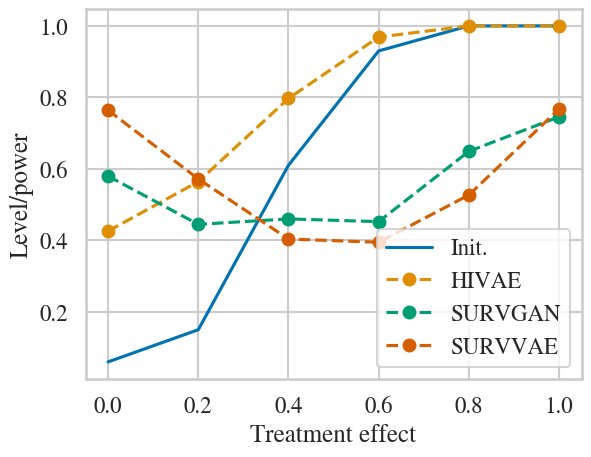

In [24]:
puiss_init = results.groupby("H0_coef").mean()["reject_H0_init"].to_numpy()
puiss_gen_hivae = results.groupby("H0_coef").mean()["reject_H0_gen_hivae"].to_numpy()
puiss_gen_survgan = results.groupby("H0_coef").mean()["reject_H0_gen_survgan"].to_numpy()
puiss_gen_survvae = results.groupby("H0_coef").mean()["reject_H0_gen_survvae"].to_numpy()
#puiss_among_reject = results[results["reject_H0_init"] ==  True].groupby(["H0_coef"]).mean()["reject_H0_gen"].to_numpy()
#puiss_among_accept = results[results["reject_H0_init"] ==  False].groupby(["H0_coef"]).mean()["reject_H0_gen"].to_numpy()
#puiss_among_accept = np.append(puiss_among_accept, np.nan)
plt.plot(treat_effects,puiss_init, '-',label = "Init.")#, markersize=1)
plt.plot(treat_effects,puiss_gen_hivae, '--', marker='o',label = "HIVAE")
plt.plot(treat_effects,puiss_gen_survgan, '--', marker='o',label = "SURVGAN")
plt.plot(treat_effects,puiss_gen_survvae, '--', marker='o',label = "SURVVAE")
#plt.scatter(treat_effects,puiss_among_reject,label = "Gen. from reject")
#plt.scatter(treat_effects,puiss_among_accept,label = "Gen. from accept")
#plt.plot(treat_effects,expected_power,label = "Expected level/power")
plt.xlabel("Treatment effect")
plt.ylabel("Level/power")
plt.legend()
plt.savefig("./dataset/" + dataset_name + "/results_independent_n_samples_" + str(n_samples) + "n_features_bytype_" + str(n_features_bytype) + ".jpeg")

## TODO point size should be proportional to sample size

## Dependent

In [50]:
M = 100
log_p_value = []
log_p_value_gen = []
simu_num = []
H0_coef = []
for t in treat_effects:
    treatment_effect = t
    for m in np.arange(M):
        if m % 10 == 0:
            print(m)
        control, treated =  simulation(beta_features, treatment_effect , n_samples, independent = False, surv_type = "surv_weibull",
                                     n_features_multiplier = 3, nnz = 3 , p_treated = 0.5, a_T = 2, a_C = 1, lamb_C = 0.15, 
                                     data_types_create = False)
        control = control.drop(columns='treatment')
        treated = treated.drop(columns='treatment')
        
        data_file_control= "./dataset/" + dataset_name + "/data_control_gen" + str(m) +".csv"
        data_file_treated= "./dataset/" + dataset_name + "/data_treated_gen" + str(m) +".csv"
        
        
        control.to_csv(data_file_control,index=False , header=False)
        treated.to_csv(data_file_treated,index=False , header=False)
        
        df_init_treated = pd.DataFrame(data_init_treated.numpy(), columns=fnames)
        df_init_control = pd.DataFrame(data_init_control.numpy(), columns=fnames)
        
        T_surv = torch.Tensor(df_init_control.time)
        T_surv_norm = (T_surv - T_surv.min()) / (T_surv.max() - T_surv.min())
        n_intervals = 5
        T_intervals = torch.linspace(0., T_surv_norm.max(), n_intervals)
        T_intervals = torch.cat([T_intervals, torch.tensor([2 * T_intervals[-1] - T_intervals[-2]])])
        intervals = [(T_intervals[i].item(), T_intervals[i + 1].item()) for i in range(len(T_intervals) - 1)]
        
        p_value_init = compute_logrank_test(control, treated)
    
        
    
        # Load and transform control data
        data_init_control_encoded, feat_types_dict, miss_mask_control, true_miss_mask_control, _ = data_processing.read_data(data_file_control, 
                                                                                                                     feat_types_file_control, 
                                                                                                                     miss_file, true_miss_file)
        data_init_control = data_processing.discrete_variables_transformation(data_init_control_encoded, feat_types_dict)
        
        # Load and transform treated data
        data_init_treated_encoded, _, _, _, _ = data_processing.read_data(data_file_treated, feat_types_file_treated, 
                                                                 miss_file, true_miss_file)
        data_init_treated = data_processing.discrete_variables_transformation(data_init_treated_encoded, feat_types_dict)
    
        data_gen_control = surv_hivae.run((data_init_control_encoded, intervals), miss_mask_control, 
                                      true_miss_mask_control, feat_types_file_control, feat_types_dict, n_generated_dataset,verbose=False)
        
        for i in range(n_generated_dataset):
            df_gen_control = pd.DataFrame(data_gen_control[i].numpy(), columns=fnames)
            df_gen_control['treatment'] = 0
            log_p_value.append(p_value_init)
            simu_num.append(m)
            p_value_gen = compute_logrank_test(df_gen_control, treated)
            log_p_value_gen.append(p_value_gen)
            H0_coef.append(treatment_effect)

0
10
20
30
40
50
60
70
80
90
0
10
20
30
40
50
60
70
80
90
0
10
20
30
40
50
60
70
80
90


In [57]:

results = pd.DataFrame({'XP_num' : simu_num, "log_pvalue_init" : log_p_value, "log_pvalue_gen" : log_p_value_gen , "H0_coef" : H0_coef})
results["reject_H0_init"] = results['log_pvalue_init'] > -np.log(0.05)
results["reject_H0_gen"] = results['log_pvalue_gen'] > -np.log(0.05)

In [58]:
results.to_csv("./dataset/" + dataset_name + "results_n_samples_" + str(n_samples) + "n_features_bytype_" + str(n_features_bytype) + ".csv")

In [59]:
alpha = 0.05
p_treated = 0.5
expected_power = []
for treatment_effect in np.arange(0,1.5,0.01):
    expected_power.append(norm.cdf(np.sqrt( D * p_treated * (1 - p_treated) * (treatment_effect)**2 ) - norm.ppf(1 - alpha/2)))

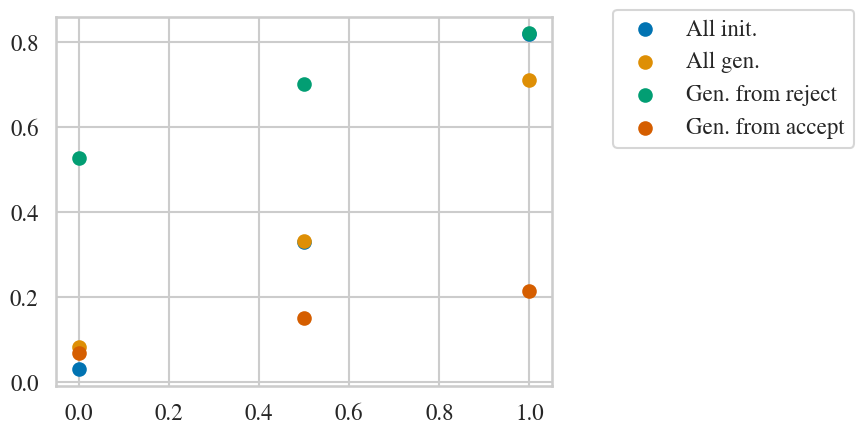

In [67]:
puiss_init = results.groupby("H0_coef").mean()["reject_H0_init"].to_numpy()
puiss_gen = results.groupby("H0_coef").mean()["reject_H0_gen"].to_numpy()
puiss_among_reject = results[results["reject_H0_init"] ==  True].groupby(["H0_coef"]).mean()["reject_H0_gen"].to_numpy()
puiss_among_accept = results[results["reject_H0_init"] ==  False].groupby(["H0_coef"]).mean()["reject_H0_gen"].to_numpy()
#puiss_among_accept = np.append(puiss_among_accept, np.nan)
plt.scatter(treat_effects,puiss_init,label = "All init.")
plt.scatter(treat_effects,puiss_gen,label = "All gen.")
plt.scatter(treat_effects,puiss_among_reject,label = "Gen. from reject")
plt.scatter(treat_effects,puiss_among_accept,label = "Gen. from accept")
#plt.plot(np.arange(0,1.5,0.01),expected_power,label = "Expected level/power")
plt.legend(bbox_to_anchor=(1.1, 1.05))